In [1]:
%matplotlib inline



# Profiles for variable V012_vent01_temp_in



In [2]:
from pymongo import MongoClient
from __future__ import print_function
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics 

import sys
sys.path.append('../../lib')
import rs_common_framework_v4 as rs

import pandas as pd
import datetime
import collections
import numpy as np
import math

from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import cm, pyplot as plt, style as st, gridspec as gd
from matplotlib.dates import YearLocator, MonthLocator
st.use('seaborn-colorblind')

import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display

py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
print("\t Connected to Mongo DB")

collection_feature_selection = 'feature_selection'
collection_statistics_daily = 'statistics_daily'
seasons = ['summer', 'winter', 't_period_1', 't_period_2']
day_type = ['working_day', 'weekend', 'holiday']
#day_type = ['working_day']

# select tag name
tag_query = {'category': {'$in': ['Temperature']}}
path_model = '../../HMM_models/Draft_models/'
file_name = 'hmm_' 

db_name = "project_db"
connection = MongoClient('localhost')  # "192.168.6.132"
collection_metadata = connection[db_name]["metadata"]
collection_series = connection[db_name]["filtered_time_series"]
collection_statistics_general = connection[db_name]["statistics_general"]

collection_statistics_daily = connection[db_name][collection_statistics_daily]
collection_feature_selection = connection[db_name][collection_feature_selection]

	 Connected to Mongo DB


In [4]:
print('Get tag names')
tag_list = rs.get_tag_names(collection_metadata, tag_query)


Get tag names


In [5]:
tag_list = ['V012_vent01_temp_in']
tag = tag_list[0]
print('Get model for ', tag)
path_open = path_model + file_name + tag + '.pkl'
print("\tReading the HMM model: \n{0}".format(path_open)) 
model = joblib.load(path_open)
n_comp = model.n_components
n_features = model.n_features

print("\tn_comp = {0}, n_features = {1}".format(n_comp,n_features))

Get model for  V012_vent01_temp_in
	Reading the HMM model: 
../../HMM_models/Draft_models/hmm_V012_vent01_temp_in.pkl
	n_comp = 36, n_features = 24


In [6]:
print('Get vector')

time_query = {
            'seasonal_label':{'$in': seasons},
            'day_type': {'$in': day_type}
            }
timeline = rs.get_timeline(collection_statistics_daily, time_query, freq=None)

df_vector = rs.get_samples(collection_series, tag=tag, timeline=timeline, normalization=False)

X = df_vector.values
print(len(timeline))

Get vector
1081


In [7]:
print("Number of samples to observe: ", len(X))
hidden_states = model.predict(X)
print("\tInfering the hidden states from the observed samples. A sequence of {0} hidden status was infered".format(len(hidden_states)))
df_y = pd.DataFrame(hidden_states, columns=['hidden_states'])
df_y.index = df_vector.index

Number of samples to observe:  1081
	Infering the hidden states from the observed samples. A sequence of 1081 hidden status was infered


In [8]:
s = dict()
for n in range(n_comp):
    s[n] = sum(model.means_[n])
print('Ordering profiles according his respectively mean')
ordered_n_comp = sorted(s,key=s.__getitem__)

Ordering profiles according his respectively mean


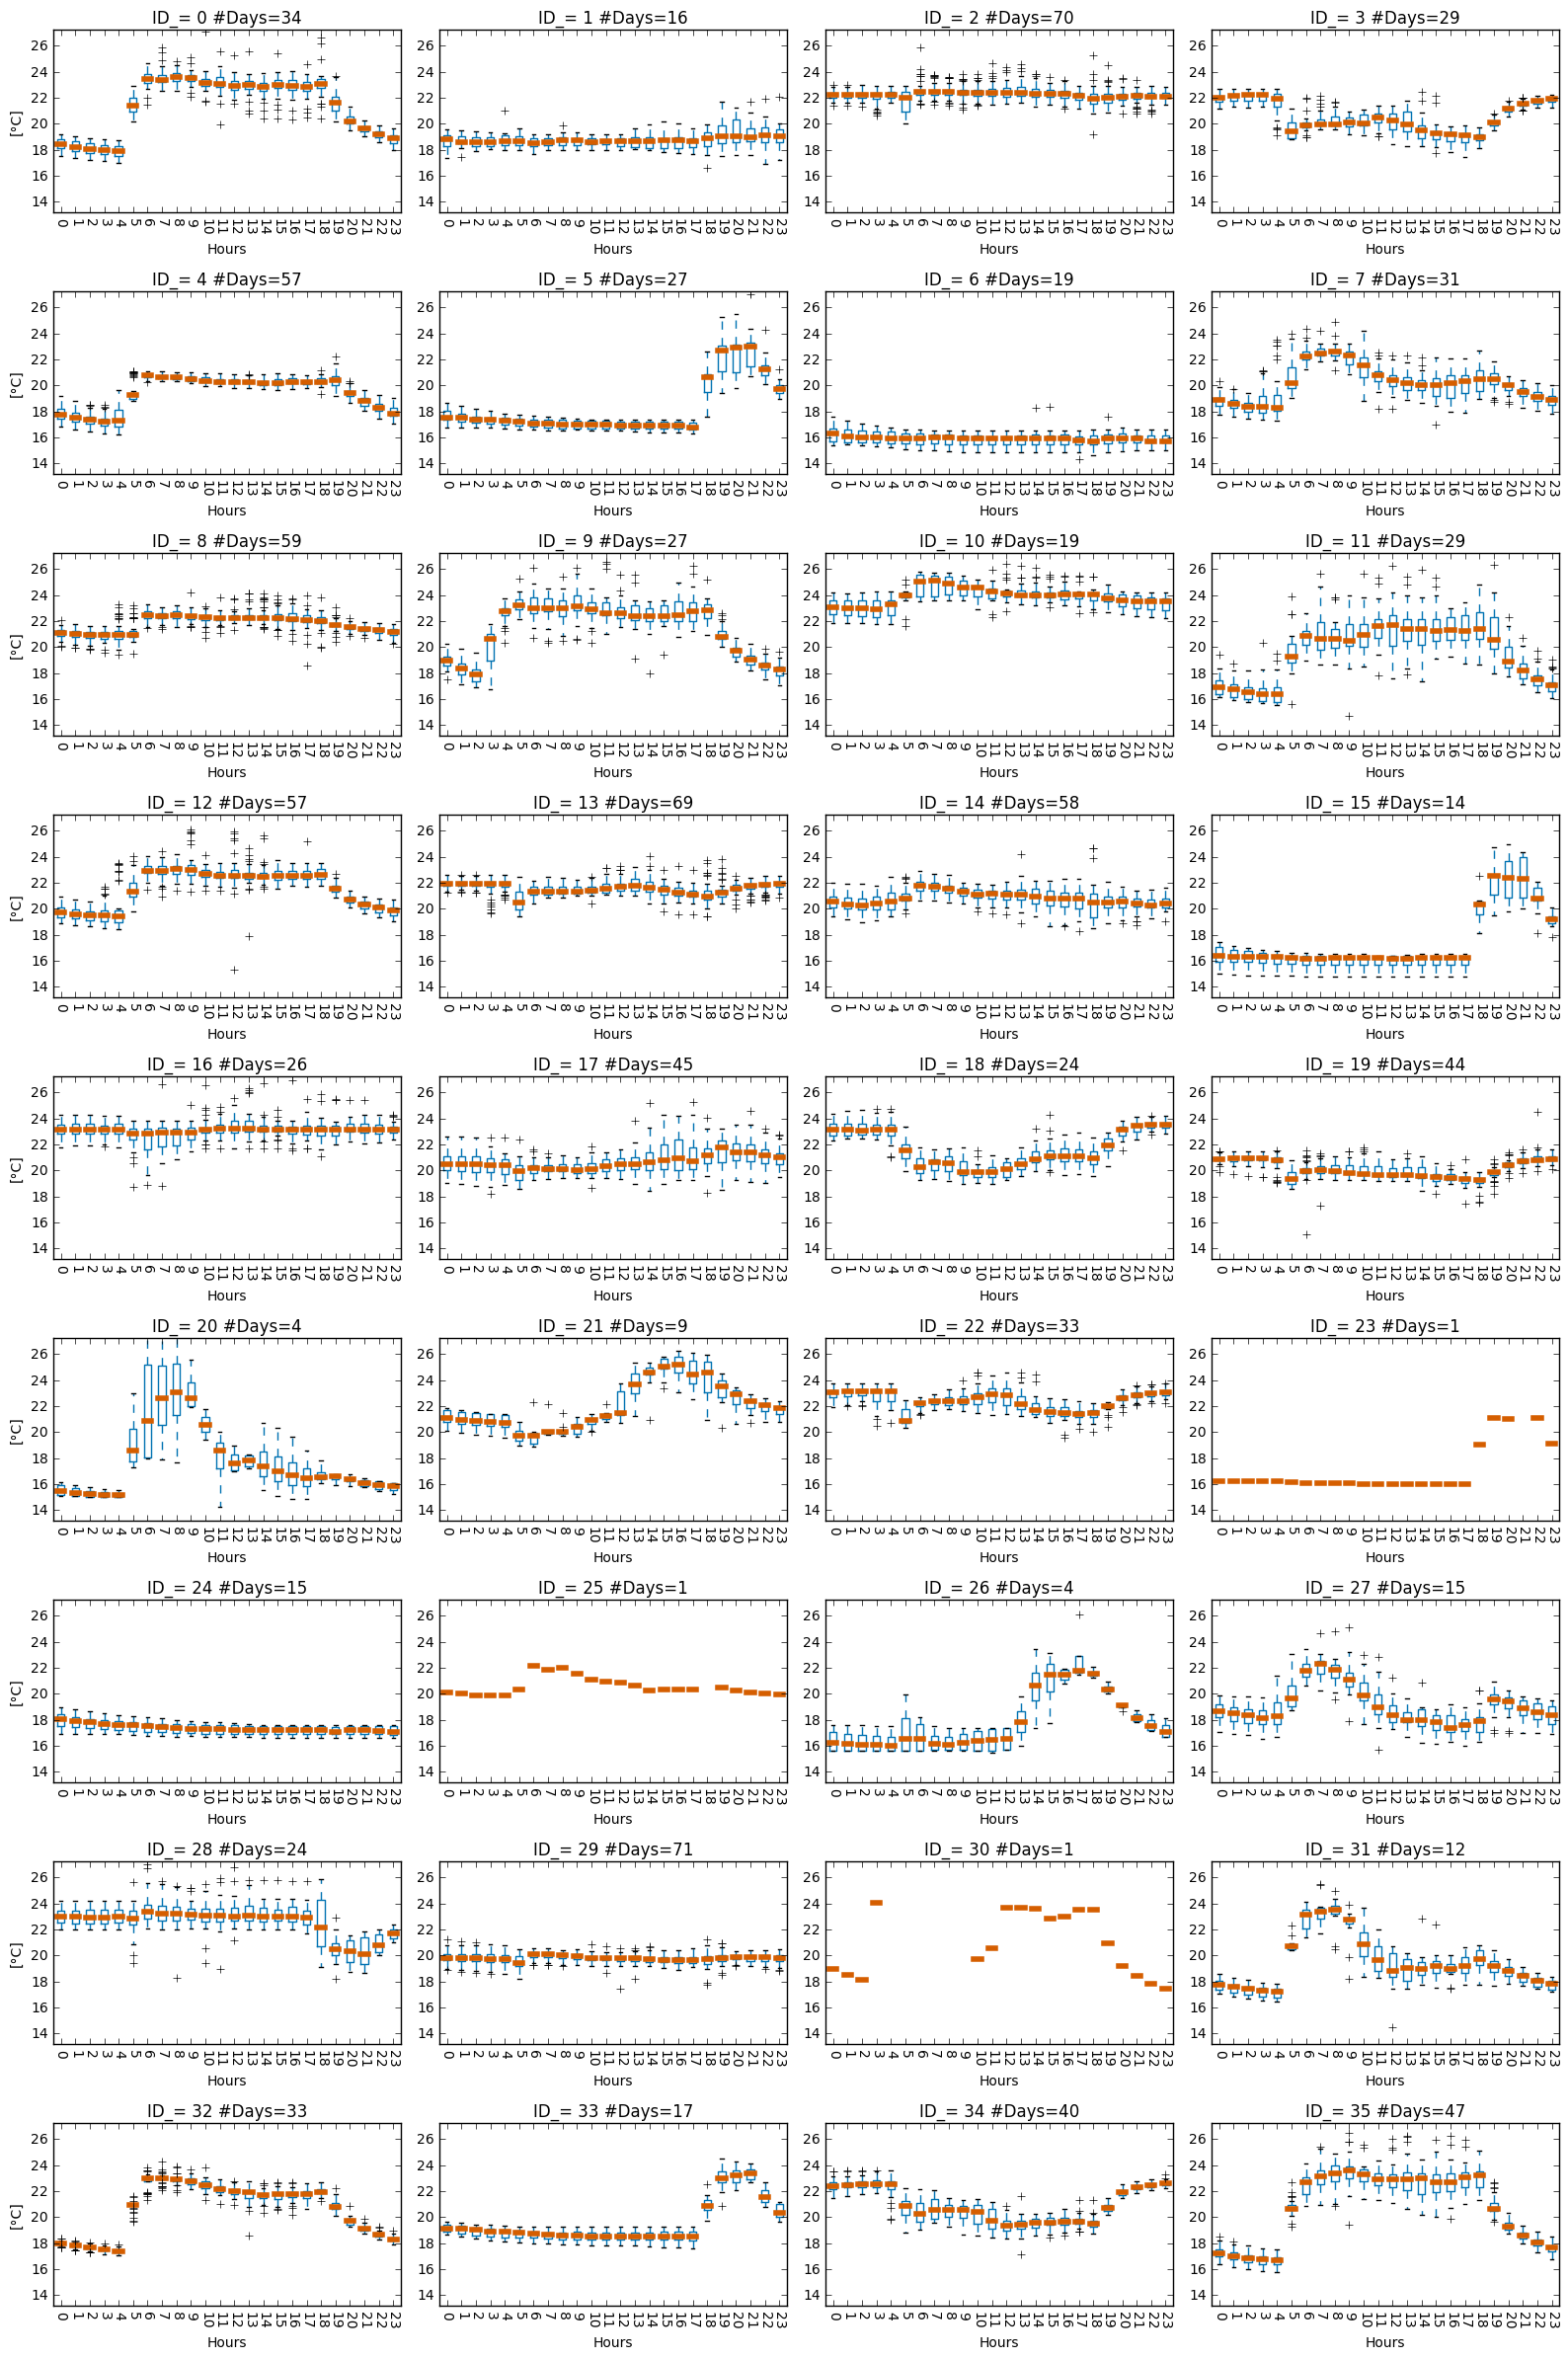

In [9]:
lol, upl = rs.get_lol_upl(collection_statistics_general, tag)
dv = (upl - lol) * 0.3
yLim = [lol-dv, upl+1.2*dv]
#yLim = [400, 900] 
n_col = 4

nrows = int(np.ceil(n_comp/n_col))
fig, axes = plt.subplots(nrows=nrows, ncols=n_col, figsize=(16,24))
medianprops = dict(linewidth=4, color='red')
i = 0
j = 0
for n in range(n_comp):
    mask = df_y[df_y['hidden_states'] == n].index
    if j>n_col-1: 
        j=0
        i+=1
    if(len(mask))>0:
        df_x = rs.get_tag_pivoted_values(collection_series, list(mask), tag)
        df_x.plot.box(ax=axes[i][j],notch=False,  medianprops=medianprops, showfliers=True)
        axes[i][j].set_ylim(yLim) 
        axes[i][j].set_xlabel('Hours')
        #axes[-1][j].set_xlabel('Hours')
        axes[i][0].set_ylabel('[°C]')
        axes[i][j].set_title('ID_= ' + str(n) + ' #Days=' + str(len(mask)))
        axes[i][j].set_xticklabels(labels = range(24), rotation=-90)
    j+=1
plt.tight_layout()
plt.show()

In [10]:
print('Compile profiles for each model, creating the observation Matrix')
M = dict()
for tag in tag_list:
    M[tag] = list()
    
    # get all the centers of the model to create the Hierarchical Cluster
    # and finally Get the Dendrogram
    # model = pack[tag]['model']
    for n in range(model.n_components):
        M[tag].append(model.means_[n])

Compile profiles for each model, creating the observation Matrix


In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

methods = ['average', 'single', 'complete', 'median', 'ward', 'weighted'] 
# 'centroid' is not included because it cause more difficult interpretation of the Dendrogram
metrics = ['euclidean', 'minkowski', 'cityblock', 'sqeuclidean']

Z_f = dict()
for tag in tag_list:
    X = np.array(M[tag])
    print('\nSearching the best linkage method and distance metric for hierchical clustering of candidates - model:', tag)
    print(X.shape)

    df_table = pd.DataFrame(index=methods,columns=metrics)
    s_method, s_metric, c_max = '','',-1 
    for method in methods:
        for metric in metrics:
            try:
                Z = linkage(X, method=method ,metric=metric)
                c, coph_dists = cophenet(Z, pdist(X))
            except:
                c = np.nan
            df_table[metric][method] = c
            if c > c_max:
                c_max = c
                s_method = method
                s_metric = metric
    print('\n \t--->The best method is {0} with metric {1}'.format(s_method,s_metric))
    Z_f[tag] = linkage(X, method='average' ,metric=s_metric)
    print(df_table)


Searching the best linkage method and distance metric for hierchical clustering of candidates - model: V012_vent01_temp_in
(36, 24)

 	--->The best method is average with metric euclidean
         euclidean minkowski cityblock sqeuclidean
average   0.800454  0.800454  0.715681    0.786857
single    0.678651  0.678651  0.628162    0.635773
complete  0.477593  0.477593  0.456232    0.428168
median    0.788097       NaN       NaN         NaN
ward       0.60413       NaN       NaN         NaN
weighted  0.784047  0.784047   0.65611    0.737233


In [20]:
threshold=10
print('using a threshold of ', threshold)

using a threshold of  10


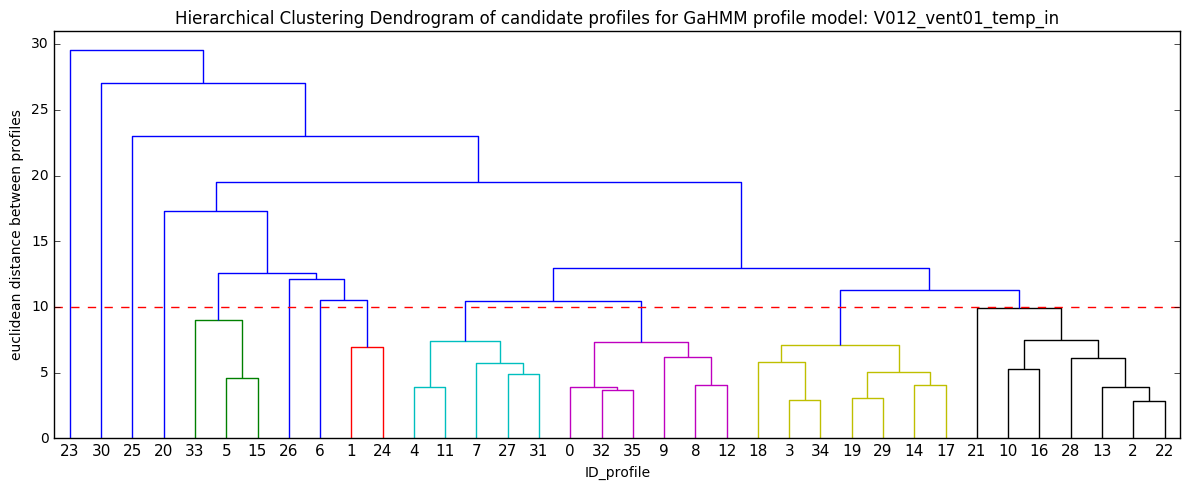

In [21]:
R = dict()
# calculate full dendrogram
for tag in tag_list:
    plt.figure(figsize=(12, 5))
    plt.title('Hierarchical Clustering Dendrogram of candidate profiles for GaHMM profile model: ' + tag)
    plt.xlabel('ID_profile')
    plt.ylabel('euclidean distance between profiles')
    R[tag] = dendrogram(
        Z_f[tag],
        #truncate_mode='lastp',  # show only the last p merged clusters
        #p=12,  # show only the last p merged clusters
        #show_leaf_counts=False,  # otherwise numbers in brackets are counts
        leaf_rotation=0.,  # rotates the x axis labels
        leaf_font_size=11.,  # font size for the x axis labels
        color_threshold=threshold,
        count_sort = 'ascending'
    )
    plt.tight_layout()
plt.plot([threshold]*1000, '--', color='red')
plt.show()

In [22]:
from scipy.cluster.hierarchy import fcluster
max_d = threshold
cluster = dict()
for tag in tag_list:
    clusters = fcluster(Z_f[tag], max_d, criterion='distance')
    list_id = set(clusters)
    cluster[tag] = dict()
    for id_c in list_id:
        id_profile = [x for x in range(len(clusters)) if clusters[x] == id_c]
        cluster[tag][id_c] = id_profile
    print('Number of cluster that were found for {0} : {1}'.format(tag,len(cluster[tag])))

df_cluster_table = pd.DataFrame(cluster)
df_cluster_table.fillna('-', inplace=True)
df_cluster_table

Number of cluster that were found for V012_vent01_temp_in : 12


,V012_vent01_temp_in
1,"[0, 8, 9, 12, 32, 35]"
2,"[4, 7, 11, 27, 31]"
3,"[3, 14, 17, 18, 19, 29, 34]"
4,"[2, 10, 13, 16, 21, 22, 28]"
5,"[5, 15, 33]"
6,"[1, 24]"
7,[6]
8,[26]
9,[20]
10,[25]


In [23]:
discord_candidates = list()
for id_ in df_cluster_table.index:
    if len(df_cluster_table.loc[id_][0]) == 1:
        discord_candidates.append(df_cluster_table.loc[id_][0][0]) 

discord_candidates

[6, 26, 20, 25, 30, 23]

Based on hierarchical clustering we spot the following discord candidates [6, 26, 20, 25, 30, 23]


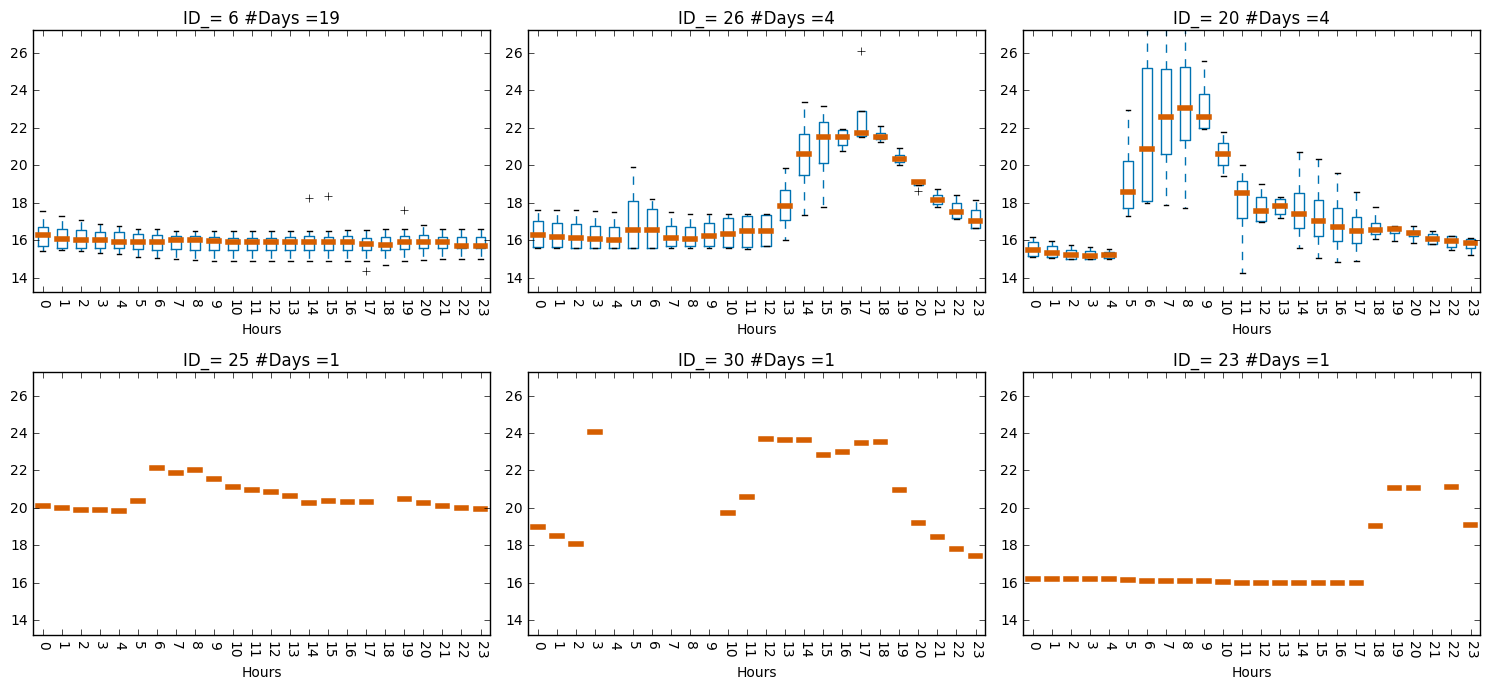

In [24]:
#ylim = [400, 900]
print('Based on hierarchical clustering we spot the following discord candidates {0}'.format(discord_candidates))
nrows = int(np.ceil(len(discord_candidates)/3))
if nrows == 1:
    nrows = 2
    
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15,7))
medianprops = dict(linewidth=4, color='red')
i = 0
j = 0

for n in discord_candidates:
    mask = df_y[df_y['hidden_states'] == n].index
    if j>2: 
        j=0
        i+=1
    if(len(mask))>0:
        df_x = rs.get_tag_pivoted_values(collection_series, list(mask), tag)
        df_x.plot.box(ax=axes[i][j],notch=False,  medianprops=medianprops, showfliers=True)
        axes[i][j].set_ylim(yLim)   
        axes[i][j].set_xlabel('Hours')
        axes[i][j].set_title('ID_= ' + str(n) + ' #Days =' + str(len(mask)))
        axes[i][j].set_xticklabels(labels = range(24), rotation=-90)
        j+=1
        
plt.tight_layout()
plt.show()

In [26]:
dates = list()
dates_discord = dict()
for n in discord_candidates:
    mask = df_y[df_y['hidden_states'] == n].index
    if(len(mask))>0:
        dates += list(mask)
        dates_discord[n] = list(mask)
print(len(dates))
print(dates)

30
['2012-12-09', '2012-12-10', '2012-12-11', '2012-12-12', '2012-12-15', '2013-01-19', '2013-01-20', '2013-01-26', '2013-02-09', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-23', '2013-03-02', '2013-03-16', '2013-03-30', '2013-12-14', '2012-12-05', '2012-12-20', '2013-01-21', '2013-02-20', '2012-12-13', '2012-12-14', '2013-01-18', '2013-02-14', '2014-05-13', '2014-12-29', '2013-03-31']


In [27]:
print('Define motifs and discords candidates')
candidates =  range(n_comp)
motif_candidates = [x for x in candidates if not x in discord_candidates]
print('motif_candidates:', motif_candidates)
print('discord_candidates:', discord_candidates)

Define motifs and discords candidates
motif_candidates: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 27, 28, 29, 31, 32, 33, 34, 35]
discord_candidates: [6, 26, 20, 25, 30, 23]


In [28]:
path_final_model = '../../HMM_models/Draft_models/' + 'named_'
file_name = tag + '.pkl'
print("Save the final model in: " + path_final_model + file_name )
#print("The hidden_state_name: ", label_comp)
final_model = dict()
final_model['model'] = model
final_model['discord_candidates'] = discord_candidates
final_model['motif_candidates'] = motif_candidates 

#save dates when the discord occurs
final_model['dates_discord'] = dates_discord


try:
    joblib.dump(final_model, filename=path_final_model + file_name, compress=3, protocol=2)
except:
    joblib.dump(final_model, filename=file_name, compress=3, protocol=2)
    
#print("Observe the mean vector and variance of each hidden states:")
#for i in motif_candidates:
#    print("{0}th hidden state".format(i+1))
#    print("mean: ", np.round(model.means_[i],1))
#    s = np.diag(model.covars_[i])
#    print("std: ", np.round(s**(0.5),2))
#    print()

Save the final model in: ../../HMM_models/Draft_models/named_V012_vent01_temp_in.pkl
